# Import necesarry libraries

In [1]:
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.manifold import TSNE

# Load CLIP

In [2]:
from clip import clip

model, preprocess_img = clip.load('ViT-B/32')

# Load & preprocess sample images

A natural image, cartoon image, emoji, sketch and text representation has been collected of each of the image categories.

In [3]:
paths = sorted(glob('./data/dim_reduction_examples/*'))

In [4]:
groups = pd.factorize([path.split('/')[-1].split('_')[0].split('.')[0] for path in paths])

group_ids = groups[0]
group_names = groups[1]

In [5]:
images_proc = []
images_orig = []

for path in paths:
    with Image.open(path) as f:
        image_pil = f.convert("RGB")
        images_orig.append(image_pil)
        image_proc = preprocess_img(f.convert("RGB"))
    images_proc.append(image_proc)

# Get images ready for inference
images_input = torch.tensor(np.stack(images_proc))

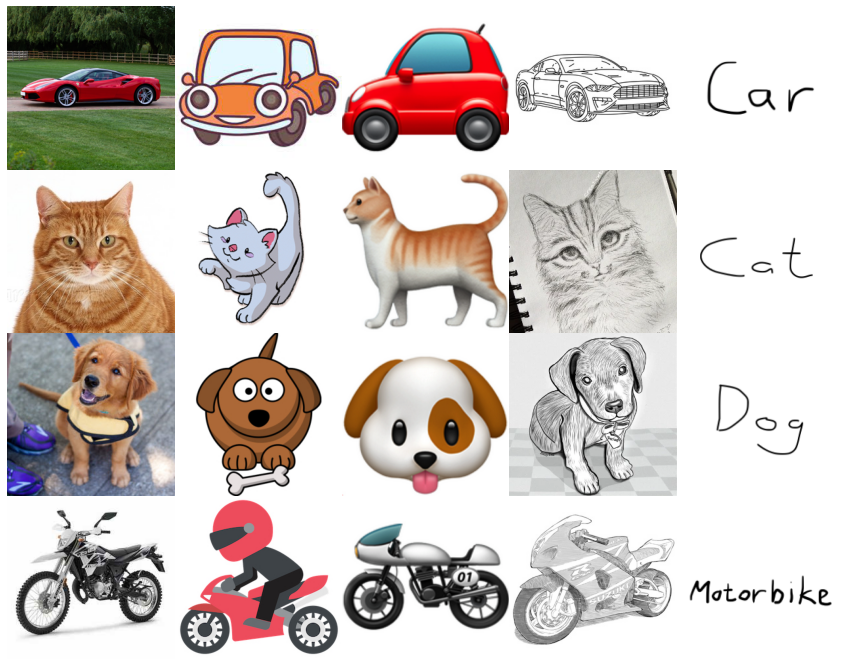

In [6]:
plt.figure(figsize = (15, 12))

for i, img in enumerate(images_orig):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(img, aspect = 'auto')

plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()

# Encode images

In [7]:
with torch.no_grad():
    image_encodings = model.encode_image(images_input).float()
    image_encodings = image_encodings / image_encodings.norm(dim = -1, keepdim = True)

# Dimensionality reduction

In [8]:
tsne = TSNE(n_components = 2, perplexity = 10)

dim_reduced = tsne.fit_transform(image_encodings.numpy())

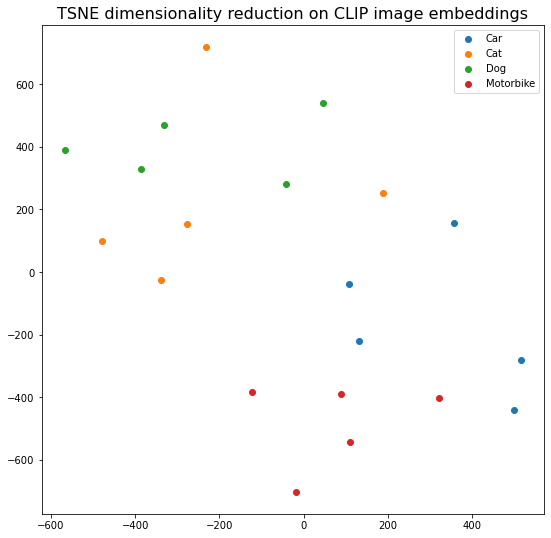

In [12]:
fig, ax = plt.subplots(figsize = (9, 9))
ax.set_title(
    'TSNE dimensionality reduction on CLIP image embeddings',
    fontsize = 16
)

for g in np.unique(group_ids):
    i = np.where(group_ids == g)
    ax.scatter(
        dim_reduced[i, 0],
        dim_reduced[i, 1],
        label = group_names[g].capitalize()
    )

plt.legend()
plt.show()

While the results aren't as tighly clustered in their specific groups as I'd first hypothesised, it's clear that cats/dogs are clustered together and cars/motorbikes to tend to cluster together. This occurs despite the images being in mixed formats (written text of the object in the image, sketch form, etc). Of course this should be intepreted with a grain of salt as we jamming a 512 dimensions into 2D for visualisation purposes, but it is interesting to explore.